<a href="https://colab.research.google.com/github/achett/Hierarchical-Model/blob/main/Bayesian_Hierarchical_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hierarchicalforecast
!pip install statsforecast
!pip install datasetsforecast
!pip install nixtlats>=0.1.0
!pip install darts
!pip install mlforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 599.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.8/452.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 910.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.7 MB/s eta 0:00:00
  Created wheel for fugue-sql-antlr: filename=fugue_sql_antlr-0.2.0-py3-none-any.whl size=158196 sha256=431a19c4f63b73212dd791cbe85b4da0f1af2ea0fa504e4724bfb4838501bddf
  Stored in directory: /root/.cache/pip/wheels/5

In [46]:
########################
# PACKAGES
########################
# !pip install -U numba statsforecast datasetsforecast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from datetime import datetime
import pymc as pm

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, OptimalCombination

# #obtain hierarchical dataset
# from datasetsforecast.hierarchical import HierarchicalData

In [3]:
##############
# PARAMS
##############
fct_periods = 12
fct_end_date = '2023-12-01'

In [4]:
##############
# DATA LOAD - BUDGET
##############
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/budgetFY23.csv'
budget = pd.read_csv(inputFile)

# List of date columns to transform
date_columns = ['4/1/2023', '5/1/2023', '6/1/2023', '7/1/2023', '8/1/2023', '9/1/2023', '10/1/2023',
                '11/1/2023', '12/1/2023', '1/1/2024', '2/1/2024', '3/1/2024']

# Melting the DataFrame
budget = budget.melt(id_vars=['country', 'product', 'Version', 'Category'], value_vars=date_columns, var_name='ds', value_name='budget')

# Transform date
budget['ds'] = pd.to_datetime(budget['ds'])

# Create unique_id
budget['unique_id'] = 'global/' + budget['country'] + '/' + budget['product']

# Filter and merge
budget = budget[budget['Category']=='Volume']
# budget['budget'] = budget['budget'].astype(float)*1000000

budget = budget.drop_duplicates()

In [5]:
##############
# DATA LOAD - PAM
##############
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/PAMFY23.csv'
pam = pd.read_csv(inputFile)

# List of date columns to transform
date_columns = ['4/1/2022', '5/1/2022', '6/1/2022', '7/1/2022', '8/1/2022',
       '9/1/2022', '10/1/2022', '11/1/2022', '12/1/2022', '1/1/2023',
       '2/1/2023', '3/1/2023', '4/1/2023', '5/1/2023', '6/1/2023', '7/1/2023',
       '8/1/2023', '9/1/2023', '10/1/2023', '11/1/2023', '12/1/2023',
       '1/1/2024', '2/1/2024', '3/1/2024', '4/1/2024', '5/1/2024', '6/1/2024',
       '7/1/2024', '8/1/2024', '9/1/2024', '10/1/2024', '11/1/2024',
       '12/1/2024', '1/1/2025', '2/1/2025', '3/1/2025']

# Melting the DataFrame
pam = pam.melt(id_vars=['country', 'product', 'Version', 'Category'], value_vars=date_columns, var_name='ds', value_name='pam')

# Transform date
pam['ds'] = pd.to_datetime(pam['ds'])

# Create unique_id
pam['unique_id'] = 'global/' + pam['country'] + '/' + pam['product']

# Filter and merge
pam = pam[pam['Category']=='Volume']
# pam['pam'] = pam['pam'].astype(float)*1000000

pam = pam.drop_duplicates()

In [39]:
########################
# PREP DATA
########################
from hierarchicalforecast.utils import aggregate

inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/volume_output.csv'
data = pd.read_csv(inputFile)

# Sample data
products2include = ['TAMSUL_TAB - Tamsulosin tab', 'TAMSULOSIN - Tamsulosin HCl', 'SOLIFENACN - Solifenacin Succinate']
data = data[data['product'].isin(products2include)]

# Create hierarchical dataframe
data['top_level'] = 'global'
data.rename(columns={'cost_object': 'middle_level'}, inplace=True)
data.rename(columns={'product': 'bottom_level'}, inplace=True)
data = data[['middle_level', 'bottom_level', 'top_level', 'ds', 'value']]

# Update columns
data['ds'] = pd.to_datetime(data['ds'])
data.rename(columns={'value': 'y'}, inplace=True)

# Create hierarchical structure and constraints
hierarchy_levels = [['top_level'],
                    ['top_level', 'middle_level'],
                    ['top_level', 'middle_level', 'bottom_level']]

Y_hier_df, S_df, tags = aggregate(df=data, spec=hierarchy_levels)
Y_hier_df = Y_hier_df.reset_index()

#split train/test sets
Y_test_df  = Y_hier_df.groupby('unique_id').tail(9)
Y_train_df = Y_hier_df.drop(Y_test_df.index)

In [57]:
########################
# RUN HIERARCHICAL
########################
# Compute base auto-ARIMA predictions
fcst = StatsForecast(df=Y_train_df,
                     models=[AutoARIMA(season_length=3)],
                     freq='M', n_jobs=-1)

Y_hat_df = fcst.forecast(h=fct_periods)

# Reconcile the base predictions
reconcilers = [
    TopDown(method='forecast_proportions')
    # OptimalCombination(method = 'ols', nonnegative=True)

]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df,
                          S=S_df, tags=tags)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/usr/local/lib/python3.10/dis

In [8]:
########################
# RUN TIMEGPT
########################
from nixtlats import TimeGPT

timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = 'CgM6BBwvTfRrFetlmNCxZzRUAmSRCXndbU1CQJhPryVhgxWp0WgIDIpV9xagvCbg4ZH3TqG012wKMGNs8L7voLeNiydi5U6nFZtnu1P3VJrqECHKzZxCyef8FwNroHEkHM9vR5ltTGAFYW7bOgiiBRzjrdzgk2FIJFsLpXAP9GgMGqa0dVd8it3zbWQ9d02T7JBf9ikAPZyy1bIU206eQZV1Zdd1Rsd9a0PMjUyWxlgg0mckf59d7lwDhzGVBUpd'
)
tgpt = timegpt.forecast(Y_train_df, h=fct_periods, freq='MS', time_col='ds', target_col='y', level=[80, 90])

In [9]:
########################
# RUN ESMOOTH
########################
from darts.models import ExponentialSmoothing
from darts import TimeSeries
import pandas as pd

# Assuming Y_train_df is your DataFrame

# Function to create a list of TimeSeries objects from the DataFrame
def create_training_list(df):
    training_list = []
    for uid in df['unique_id'].unique():
        temp_df = df[df['unique_id'] == uid].copy()
        temp_df.set_index('ds', inplace=True)
        ts = TimeSeries.from_dataframe(temp_df, value_cols='y')
        training_list.append(ts)
    return training_list

# Your existing functions with slight modifications for Darts
def ESModelBuilder(training_list):
    listofESmodels = []
    for ts in training_list:
        ES_model = ExponentialSmoothing()
        ES_model.fit(ts)
        listofESmodels.append(ES_model)
    return listofESmodels

def ESForecaster(model_list):
    listofESpreds = []
    for model in model_list:
        pred_ES = model.predict(n=fct_periods)
        listofESpreds.append(pred_ES)
    return listofESpreds

# Creating a list of TimeSeries objects
training_list = create_training_list(Y_train_df)

# Building models
listofESmodels = ESModelBuilder(training_list)

# Generating forecasts
listofESpreds = ESForecaster(listofESmodels)

# listofESpreds now contains the forecasts for each unique_id
# Create an empty DataFrame to store the results
esmooth = pd.DataFrame(columns=['unique_id', 'ds', 'ES'])

# Get unique IDs
unique_ids = Y_train_df['unique_id'].unique()

# Iterate over the forecasts and unique IDs
for uid, forecast in zip(unique_ids, listofESpreds):
    # Convert forecast to DataFrame
    forecast_df = forecast.pd_dataframe()

    # Reset index to make 'ds' a column
    forecast_df.reset_index(inplace=True)

    # Rename columns to match the desired output
    forecast_df.rename(columns={'index': 'ds', forecast_df.columns[1]: 'ES'}, inplace=True)

    # Add the unique_id column
    forecast_df['unique_id'] = uid

    # Append to the final DataFrame
    esmooth = pd.concat([esmooth, forecast_df], ignore_index=True)

# final_df now contains the data in the format ['unique_id', 'ds', 'ES']
esmooth.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_

,unique_id,ds,ES
0,global,2023-04-01,1.035175e+08
1,global,2023-05-01,8.905444e+07
2,global,2023-06-01,1.082709e+08
3,global,2023-07-01,1.120722e+08
4,global,2023-08-01,1.071366e+08


In [10]:
########################
# RUN PROPHET
########################
from darts.models import Prophet
from darts import TimeSeries
import pandas as pd

# Assuming Y_train_df is your DataFrame

# Function to create a list of TimeSeries objects from the DataFrame
def create_training_list(df):
    training_list = []
    for uid in df['unique_id'].unique():
        temp_df = df[df['unique_id'] == uid].copy()
        temp_df.set_index('ds', inplace=True)
        ts = TimeSeries.from_dataframe(temp_df, value_cols='y')
        training_list.append(ts)
    return training_list

# Modified function to use Prophet models
def ProphetModelBuilder(training_list):
    listOfProphetModels = []
    for ts in training_list:
        prophet_model = Prophet()
        prophet_model.fit(ts)
        listOfProphetModels.append(prophet_model)
    return listOfProphetModels

# Function to generate forecasts with Prophet models
def ProphetForecaster(model_list):
    listOfProphetPreds = []
    for model in model_list:
        pred_Prophet = model.predict(n=fct_periods)
        listOfProphetPreds.append(pred_Prophet)
    return listOfProphetPreds

# Creating a list of TimeSeries objects
training_list = create_training_list(Y_train_df)

# Building Prophet models
listOfProphetModels = ProphetModelBuilder(training_list)

# Generating forecasts with Prophet
listOfProphetPreds = ProphetForecaster(listOfProphetModels)

# Convert predictions to a DataFrame
prophet_df = pd.DataFrame(columns=['unique_id', 'ds', 'Prophet'])

# Get unique IDs
unique_ids = Y_train_df['unique_id'].unique()

# Iterate over the forecasts and unique IDs
for uid, forecast in zip(unique_ids, listOfProphetPreds):
    # Convert forecast to DataFrame
    forecast_df = forecast.pd_dataframe()

    # Reset index to make 'ds' a column
    forecast_df.reset_index(inplace=True)

    # Rename columns to match the desired output
    forecast_df.rename(columns={'index': 'ds', forecast_df.columns[1]: 'Prophet'}, inplace=True)

    # Add the unique_id column
    forecast_df['unique_id'] = uid

    # Append to the final DataFrame
    prophet_df = pd.concat([prophet_df, forecast_df], ignore_index=True)

# prophet_df now contains the data in the format ['unique_id', 'ds', 'Prophet']
prophet_df.head()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrlo8atd/rl79mg0y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqrlo8atd/qmbnroi3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96423', 'data', 'file=/tmp/tmpqrlo8atd/rl79mg0y.json', 'init=/tmp/tmpqrlo8atd/qmbnroi3.json', 'output', 'file=/tmp/tmpqrlo8atd/prophet_modelifwqmtj_/prophet_model-20240121202204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:22:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

,unique_id,ds,Prophet
0,global,2023-04-01,1.531804e+08
1,global,2023-05-01,1.438514e+08
2,global,2023-06-01,1.572145e+08
3,global,2023-07-01,1.589547e+08
4,global,2023-08-01,1.531909e+08


In [157]:
########################
# RUN LGBM
########################
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn import linear_model

# Feature Engineering
inputFile = '/content/drive/MyDrive/Colab Notebooks/Revenue Prediction/data/volume_output.csv'
features = pd.read_csv(inputFile)

features['unique_id'] = 'global' + '/' + features['cost_object'] + '/' + features['product']
features = features[['unique_id', 'cost_object', 'product']].drop_duplicates()

Y_train_df_ml = Y_train_df.merge(features, on='unique_id', how='left')

# Creating LabelEncoder instance
label_encoder = LabelEncoder()

# Encoding 'cost_object' and 'product'
Y_train_df_ml['cost_object_encoded'] = label_encoder.fit_transform(Y_train_df_ml['cost_object'])
Y_train_df_ml['product_encoded'] = label_encoder.fit_transform(Y_train_df_ml['product'])

# Subset
Y_train_df_ml2 = Y_train_df_ml[['unique_id', 'ds', 'y', 'cost_object_encoded','product_encoded']]

models = [
    # linear_model.BayesianRidge(),
    # ElasticNet(alpha=0.08, l1_ratio=0.5),
    lgb.LGBMRegressor(verbosity=-1),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean


@njit
def rolling_mean_quarter(x):
    return rolling_mean(x, window_size=6)


fcst = MLForecast(
    models=models,
    freq='MS',
    lags=[1, 2, 3, 6, 12],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_quarter]
    },
    date_features=['month']
    # ,target_transforms=[Differences([1])],
)

fcst.fit(Y_train_df_ml2, static_features=['cost_object_encoded', 'product_encoded'])

# Predict
ml_models = fcst.predict(fct_periods)
ml_models.head()

,unique_id,ds,ElasticNet,XGBRegressor,RandomForestRegressor
0,global,2023-04-01,1.022447e+08,128328360.0,1.006427e+08
1,global,2023-05-01,9.489934e+07,126688704.0,1.143249e+08
2,global,2023-06-01,9.902559e+07,99688024.0,1.019839e+08
3,global,2023-07-01,9.575961e+07,140104624.0,1.088851e+08
4,global,2023-08-01,9.041902e+07,115845344.0,1.121186e+08


In [158]:
# Create data to plot
data2plot = Y_rec_df.reset_index()
data2plot['ds'] = pd.to_datetime(data2plot['ds'])
data2plot['ds'] = data2plot['ds'] + pd.Timedelta(days=1)
data2plot = data2plot.merge(Y_test_df, on=['ds', 'unique_id'], how='left')
data2plot.rename(columns={'y': 'Actuals'}, inplace=True)

# Add budget, pam
data2plot = data2plot.merge(budget[['unique_id', 'ds', 'budget']], on=['ds', 'unique_id'], how='left')
data2plot = data2plot.merge(pam[['unique_id', 'ds', 'pam']], on=['ds', 'unique_id'], how='left')

# Add tgpt
tgpt['ds'] = pd.to_datetime(tgpt['ds'])
data2plot = data2plot.merge(tgpt[['unique_id', 'ds', 'TimeGPT']], on=['ds', 'unique_id'], how='left')

# Add esmooth
data2plot = data2plot.merge(esmooth[['unique_id', 'ds', 'ES']], on=['ds', 'unique_id'], how='left')

# Add prophet
data2plot = data2plot.merge(prophet_df[['unique_id', 'ds', 'Prophet']], on=['ds', 'unique_id'], how='left')

# Add ml_models
data2plot = data2plot.merge(ml_models, on=['ds', 'unique_id'], how='left')

# Add older actuals
older_actuals = Y_train_df.copy()
older_actuals.rename(columns={'y': 'Actuals (Train)'}, inplace=True)
data2plot = pd.concat([data2plot, older_actuals])

# Rename columns
data2plot.columns = ['unique_id', 'ds', 'AutoARIMA','AA_H', 'Actuals', 'Budget','PAM', 'TimeGPT', 'ES','Prophet', 'LGBM', 'XGB', 'RF', 'Actuals (Train)']

# Filter to end date
data2plot = data2plot[data2plot['ds']<=fct_end_date]

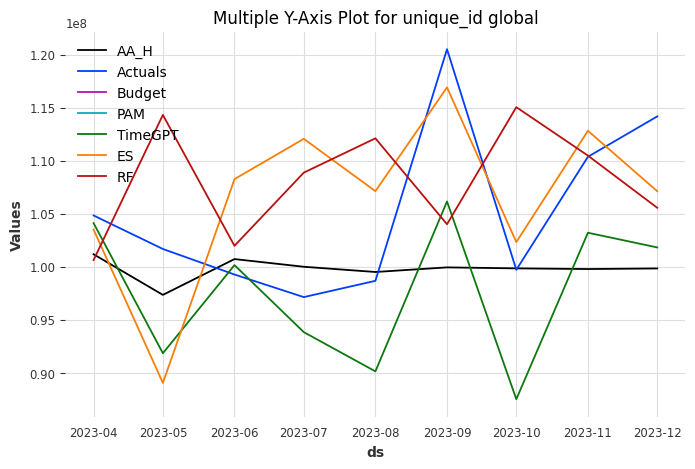

,Y Column,Percentage Difference
0,AA_H,-5.091514
1,Actuals,0.000000
2,Budget,-100.000000
3,PAM,-100.000000
4,TimeGPT,-7.139563
5,ES,1.354958
6,RF,2.815487


In [65]:
# # Install ipywidgets if not already installed
# !pip install ipywidgets

import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import pandas as pd

# Example DataFrame
# data = pd.DataFrame({'x': range(1, 11), 'y1': range(10, 20), 'y2': range(20, 30)})

# Update the function to include filtering based on 'unique_id'
def plot_data(unique_id, x_column, y_columns):
    # Filter data based on selected unique_id
    filtered_data = data2plot[data2plot['unique_id'] == unique_id]

    # Plotting
    plt.figure(figsize=(8, 5))
    for y_column in y_columns:
        plt.plot(filtered_data[x_column], filtered_data[y_column], label=y_column)
    plt.xlabel(x_column)
    plt.ylabel('Values')
    plt.title(f'Multiple Y-Axis Plot for unique_id {unique_id}')
    plt.legend()
    plt.show()

    # Displaying the sum table
    display_data = filtered_data[[x_column] + list(y_columns)].copy()

    # Create a sum row
    sum_values = {x_column: 'Sum'}
    for col in list(y_columns):
        sum_values[col] = display_data[col].sum()
    sum_row = pd.DataFrame([sum_values])

    display_data = pd.concat([display_data, sum_row], ignore_index=True)

    # Calculating and displaying the percentage difference table
    perc_diff_rows = []
    actuals_sum = sum_values['Actuals']
    for y_col in y_columns:
        y_sum = sum_values[y_col]
        perc_diff = ((y_sum - actuals_sum) / actuals_sum) * 100 if actuals_sum != 0 else None
        perc_diff_rows.append({'Y Column': y_col, 'Percentage Difference': perc_diff})

    perc_diff_data = pd.DataFrame(perc_diff_rows)
    display(perc_diff_data)
    # display(display_data)

# Create widgets
# unique_id_selector = widgets.Dropdown(options=data2plot['unique_id'].unique(), description='unique_id:')
# Create widgets
unique_id_selector = widgets.SelectionSlider(
    options=data2plot['unique_id'].unique(),
    description='unique_id:',
    orientation='horizontal',
    readout=True
)

x_column = widgets.Dropdown(options=data2plot.columns, value=data2plot.columns[1], description='X-axis:')
y_columns = widgets.SelectMultiple(options=data2plot.columns, value=[data2plot.columns[3], data2plot.columns[4], data2plot.columns[5], data2plot.columns[6], data2plot.columns[7], data2plot.columns[8]], description='Y-axis:')

# Display interactive plot
interact(plot_data, unique_id=unique_id_selector, x_column=x_column, y_columns=y_columns)
print('hi')

In [159]:
########################
# CHECK WINNER
########################
# Filter data2plot
data4metrics = data2plot[data2plot['ds'].isin(budget['ds'].unique())]
data4metrics = data4metrics[data4metrics['ds']<=fct_end_date]

numeric_cols = data4metrics.columns.drop(['unique_id', 'ds'])

# Sum up the values for each unique_id
summed_df = data4metrics.groupby('unique_id')[numeric_cols].sum()

# Calculate percentage differences from 'Actuals'
percentage_diff = summed_df.subtract(summed_df['Actuals'], axis=0).div(summed_df['Actuals'], axis=0).abs()

# Drop the 'Actuals' column as we don't need to compare it with itself
percentage_diff.drop(columns=['Actuals', 'Actuals (Train)', 'AA_H', 'AutoARIMA', 'TimeGPT', 'ES', 'PAM', 'XGB', 'RF', 'Prophet'], inplace=True)

# Find the column with the lowest percentage difference for each unique_id
min_diff_col = percentage_diff.idxmin(axis=1)

# Add this as a new column in your original DataFrame
data4metrics['lowest_diff_col'] = data4metrics['unique_id'].map(min_diff_col)

data4metrics[data4metrics['unique_id'].isin(budget['unique_id'])].groupby('lowest_diff_col')['unique_id'].nunique()

lowest_diff_col
Budget    81
LGBM      35
Name: unique_id, dtype: int64

In [15]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=10)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=10)
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=10)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=10)

    # Priors
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=n_groups)  # group-specific intercepts
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=n_groups)  # group-specific slopes
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value
    mu = alpha[group_indicator] + beta[group_indicator] * x

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Sampling
    trace = pm.sample(2000, tune=1000)

NameError: name 'n_groups' is not defined

In [ ]:
# Checking the trace
pm.plot_trace(trace,var_names=['alpha','beta'])
plt.show()

In [ ]:
# Posterior samples
alpha_samples = trace.posterior['alpha'].values
beta_samples = trace.posterior['beta'].values

# New x values for predictions
x_new = np.linspace(0, 10, 200)

plt.figure(figsize=(10, 5))

# Plot raw data and predictions for each group
for i in range(n_groups):
    # Plot raw data

    plt.plot(x[group_indicator == i], y[group_indicator == i], 'o', color=colors[i], label=f'Group {i+1} observed')
    x_new = x[group_indicator == i]
    # Generate and plot predictions
    alpha = trace.posterior.sel(alpha_dim_0=i,beta_dim_0=i)['alpha'].values
    beta = trace.posterior.sel(alpha_dim_0=i,beta_dim_0=i)['beta'].values
    y_hat = alpha[..., None] + beta[..., None] * x_new[None,:]
    y_hat_mean = y_hat.mean(axis=(0, 1))
    y_hat_std = y_hat.std(axis=(0, 1))
    plt.plot(x_new, y_hat_mean, color=colors[i], label=f'Group {i+1} predicted')
    plt.fill_between(x_new, y_hat_mean - 2*y_hat_std, y_hat_mean + 2*y_hat_std, color=colors[i], alpha=0.3)

plt.title('Raw Data with Posterior Predictions by Group')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()